In [1]:
!pip install transformers diffusers torch torchvision tensorflow pillow matplotlib nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 14.3 MB/s eta 0:00:00


In [5]:
from transformers import BertTokenizer, TFBertModel, GPT2LMHeadModel, GPT2Tokenizer
from diffusers import StableDiffusionPipeline
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models.inception import inception_v3
from torchvision import transforms
from torch.nn import functional as F
import nltk
from nltk.translate.bleu_score import sentence_bleu

In [6]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt2_model = GPT2LMHeadModel.from_pretrained('gpt2')

pipe = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1")
pipe.to("cuda")

inception_model = inception_v3(pretrained=True, transform_input=False)
inception_model.eval()
inception_model.to('cuda')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [8]:
preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = preprocess(image)
    image = image.unsqueeze(0).to('cuda')
    return image

In [11]:
def calculate_inception_score(images, splits=10):
    preds = []

    for image_path in images:
        image = preprocess_image(image_path)
        with torch.no_grad():
            pred = inception_model(image)
            preds.append(F.softmax(pred, dim=1).cpu().numpy())

    preds = np.concatenate(preds, axis=0)
    scores = []

    for i in range(splits):
        part = preds[(i * preds.shape[0] // splits):((i + 1) * preds.shape[0] // splits), :]
        py = np.mean(part, axis=0)

        scores.append(np.exp(np.mean(np.sum(part * np.log(part / (py + 1e-16)), axis=1))))

    return np.mean(scores), np.std(scores)

In [12]:
def encode_text_with_bert(text):
    inputs = bert_tokenizer(text, return_tensors='tf', truncation=True, padding=True)
    outputs = bert_model(**inputs)
    return outputs.last_hidden_state[:, 0, :].numpy()

In [13]:
def generate_text_with_gpt2(prompt, context_embedding):
    context = " ".join(["The man is a europian with blonde hair and feather hat has plain colour"])
    enhanced_prompt = f"{prompt}. {context}"

    inputs = gpt2_tokenizer(enhanced_prompt, return_tensors='pt')
    outputs = gpt2_model.generate(inputs['input_ids'], max_length=100, num_return_sequences=1, temperature=0.7)
    return gpt2_tokenizer.decode(outputs[0], skip_special_tokens=True)

In [14]:
def tokenize_text(text):
    return nltk.word_tokenize(text.lower())

In [15]:
def calculate_bleu_score(reference, candidate):
    reference_tokens = tokenize_text(reference)
    candidate_tokens = tokenize_text(candidate)
    return sentence_bleu([reference_tokens], candidate_tokens)

In [16]:
def enhance_prompt_with_bert(text):
    embeddings = encode_text_with_bert(text)
    enhanced_text = generate_text_with_gpt2(text, embeddings)
    return enhanced_text

In [17]:
def generate_images_from_prompt(prompt, num_images=5):
    enhanced_prompt = enhance_prompt_with_bert(prompt)
    print("Enhanced Prompt:", enhanced_prompt)

    image_paths = []
    for i in range(num_images):
        image = pipe(enhanced_prompt).images[0]

        image_path = f"generated_image_{i}.png"
        image.save(image_path)
        image_paths.append(image_path)

    return image_paths

In [18]:
prompt = "A 16th-century nobleman with a beard, wearing a velvet tunic and a feathered hat"
num_images = 5
image_paths = generate_images_from_prompt(prompt, num_images)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Token indices sequence length is longer than the specified maximum sequence length for this model (95 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['man of the people. the man is a man of the people, a man of the']


Enhanced Prompt: A 16th-century nobleman with a beard, wearing a velvet tunic and a feathered hat. The man is a europian with blonde hair and feather hat has plain colour.

The man is a man of the people, a man of the people, a man of the people.

The man is a man of the people, a man of the people, a man of the people.

The man is a man of the people, a man of the


  0%|          | 0/50 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['man of the people. the man is a man of the people, a man of the']


  0%|          | 0/50 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['man of the people. the man is a man of the people, a man of the']


  0%|          | 0/50 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['man of the people. the man is a man of the people, a man of the']


  0%|          | 0/50 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['man of the people. the man is a man of the people, a man of the']


  0%|          | 0/50 [00:00<?, ?it/s]

Inception Score: nan, Std: nan



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Avg BLEU Score: 0.1592272096396538



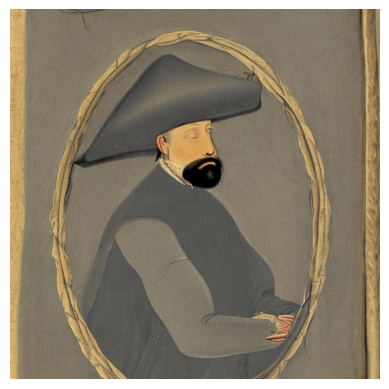

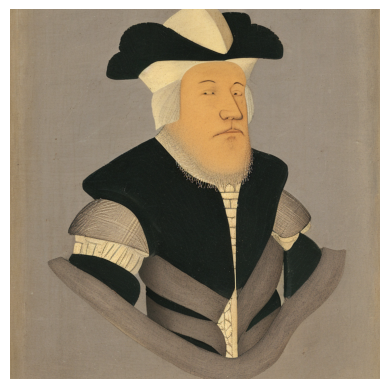

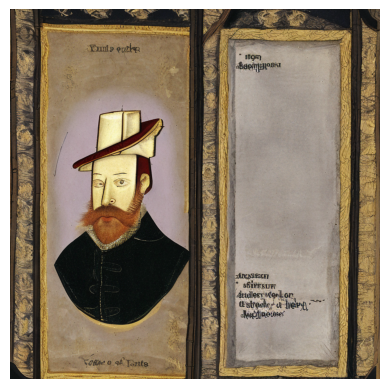

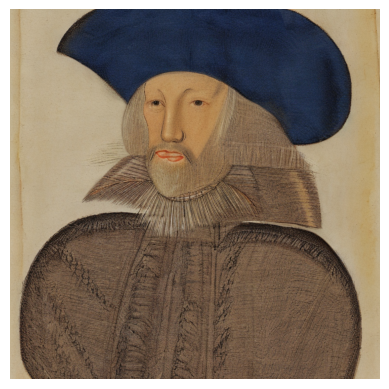

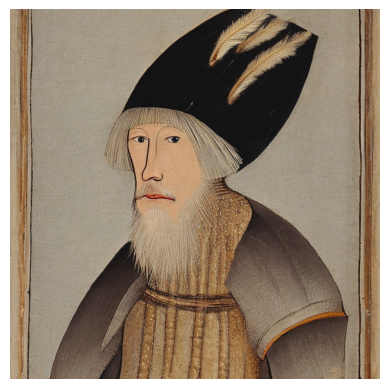

In [19]:
inception_score, inception_std = calculate_inception_score(image_paths)
print(f"Inception Score: {inception_score}, Std: {inception_std}\n")

enhanced_prompt = enhance_prompt_with_bert(prompt)
bleu_scores = [calculate_bleu_score(prompt, enhanced_prompt) for _ in range(num_images)]
avg_bleu_score = np.mean(bleu_scores)
print(f"Avg BLEU Score: {avg_bleu_score}\n")

for image_path in image_paths:
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()